<a href="https://colab.research.google.com/github/iamscj/fakenewsdetection/blob/main/fake_news_detection_transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [4]:
from tensorflow.keras.preprocessing.text import one_hot

In [5]:
import pandas as pd

In [6]:
def read_dataframe(tsv_file: str) -> pd.DataFrame: # .tsv to df

    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)

    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)

    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'title',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'author',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.

        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.

        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

    return df

#create a dataframe from the training data
df = read_dataframe('/content/drive/MyDrive/FakeNewsDataset/train.tsv')

In [7]:
df['title'][0]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [8]:
df['label'] = df['label'].apply(lambda x: 0 if x in ['mostly-true', 'true'] else 1)
df.head()

,id,label,title,subjects,author,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,0,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


In [9]:
###Drop Nan Values
df=df.dropna()

In [10]:
## Get the Independent Features

X=df.drop('label',axis=1)

In [11]:
## Get the Dependent features
y=df['label']

In [12]:
y.value_counts()

1    6601
0    3638
Name: label, dtype: int64

In [13]:
X.shape

(10239, 13)

In [14]:
y.shape

(10239,)

In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
### Vocabulary size
voc_size=5000

In [ ]:
messages=X.copy()

In [24]:
messages['title'][4]

NameError: ignored

In [ ]:
#reset the index in messages as nan values are dropped
messages.reset_index(inplace=True)

In [ ]:
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Preprocessing of Data**
**Role of Stemming** : The role of stemming is to normalize words so that different forms of the same word are treated as identical, even if they have different suffixes or prefixes.

In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):

    #replace unnecessary characters with spaces using regex
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])

    #lower
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

print(len(messages))

10239


In [ ]:
corpus[0:5]

['declin coal start start natur ga took start begin presid georg w bush administr',
 'hillari clinton agre john mccain vote give georg bush benefit doubt iran',
 'health care reform legisl like mandat free sex chang surgeri',
 'econom turnaround start end term',
 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad']

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]
# onehot_repr

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 1071 4363 4016]
 [   0    0    0 ... 4569 4160  617]
 [   0    0    0 ... 4618 4916  290]
 ...
 [   0    0    0 ...  551 1123  398]
 [   0    0    0 ... 1295  695 1368]
 [   0    0    0 ...  452  474   22]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0, 2878, 4300, 3669, 3669, 1291,
       3588, 4580, 3669, 2554, 4036, 4080, 1071, 4363, 4016], dtype=int32)

# Creating The Model (LSTM)

In [ ]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100)) # 100 neurons, so if this increases acc incr later overfitting
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # adam optimizer change the parameters for training
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(10239, (10239,))

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
X_final.shape,y_final.shape

((10239, 20), (10239,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# **Model Training**


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) # 64 words for each epoch

Epoch 1/10
108/108 [==============================] - 18s 125ms/step - loss: 0.6528 - accuracy: 0.6437 - val_loss: 0.6369 - val_accuracy: 0.6428
Epoch 2/10
108/108 [==============================] - 8s 77ms/step - loss: 0.5974 - accuracy: 0.6771 - val_loss: 0.6352 - val_accuracy: 0.6555
Epoch 3/10
108/108 [==============================] - 4s 36ms/step - loss: 0.5328 - accuracy: 0.7239 - val_loss: 0.7390 - val_accuracy: 0.6493
Epoch 4/10
108/108 [==============================] - 4s 38ms/step - loss: 0.4848 - accuracy: 0.7617 - val_loss: 0.7356 - val_accuracy: 0.6102
Epoch 5/10
108/108 [==============================] - 2s 23ms/step - loss: 0.4257 - accuracy: 0.7988 - val_loss: 0.8527 - val_accuracy: 0.6091
Epoch 6/10
108/108 [==============================] - 7s 65ms/step - loss: 0.3726 - accuracy: 0.8281 - val_loss: 0.9436 - val_accuracy: 0.5738
Epoch 7/10
108/108 [==============================] - 4s 34ms/step - loss: 0.3277 - accuracy: 0.8509 - val_loss: 0.9890 - val_accuracy: 0.59

In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 1s 2ms/step


# **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test,y_pred)

array([[ 490,  716],
       [ 706, 1467]])

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

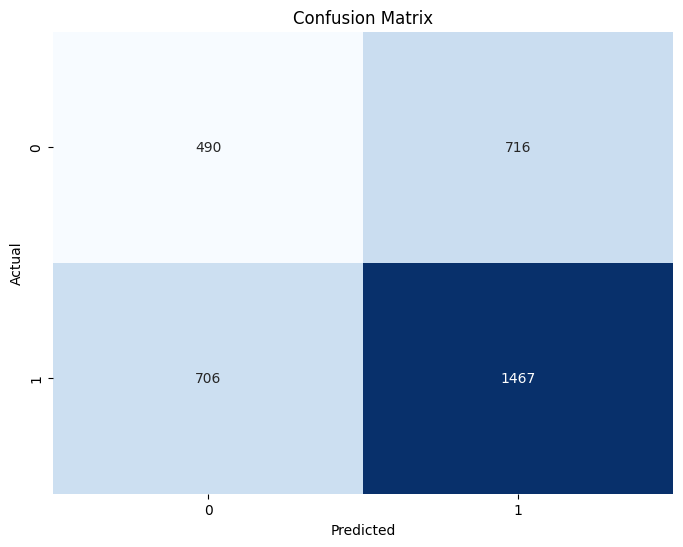

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5791654335602249

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    ps = PorterStemmer()
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review


# Function to predict
def predict_statement(statement, model):
    voc_size = 5000
    sent_length = 20

    # Preprocess the user input
    processed_statement = preprocess_text(statement)

    # One-hot encode the preprocessed statement
    input_data = [one_hot(processed_statement, voc_size)]
    padded_input = pad_sequences(input_data, padding='pre', maxlen=sent_length)

    # Make a prediction
    prediction = model.predict(np.array(padded_input))

    # Convert prediction to 0 or 1
    prediction = (prediction > 0.5).astype(int)

    return prediction[0][0]

In [ ]:
# # Load the pre-trained model
# model = load_model()

# Take input from the user
# user_input = input("Enter a statement: ")

#example 1 (real news)
# user_input = """Hillary Clinton agrees with John McCain
# "by voting to give George Bush the benefit of the doubt on Iran."""


# example 2 (fake news)
user_input = """Health care reform legislation is likely to mandate free sex change surgeries."""
# Predict the label (0 or 1)
result = predict_statement(user_input, model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 18ms/step
The statement is false or barely true.


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/FakenewsModel/fake_news_predict.h5')

In [ ]:
#example 1 (real news)
user_input = """Hillary Clinton agrees with John McCain
"by voting to give George Bush the benefit of the doubt on Iran."""

result = predict_statement(user_input, loaded_model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 329ms/step
The statement is mostly true or true.


In [ ]:
#example 2 (real news)
user_input = """Karnataka bandh: Cabs, autos off roads, chaos at airport, several detained"""

result = predict_statement(user_input, loaded_model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 18ms/step
The statement is mostly true or true.


## **Using Transformer Model**

In [16]:
!pip install transformers

In [17]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification


# Block 1: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(df['title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Block 2: Create TensorFlow datasets with labels
dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), df['label'].tolist()))
dataset = dataset.shuffle(len(dataset)).batch(8)

# Block 3: Model Initialization
modelTransformerModel = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Block 4: Model Compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
modelTransformerModel.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Block 5: Model Training
history = modelTransformerModel.fit(dataset, epochs=3)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1280/1280 [==============================] - 1252s 941ms/step - loss: 0.6298 - accuracy: 0.6523
Epoch 2/3
1280/1280 [==============================] - 1202s 939ms/step - loss: 0.5754 - accuracy: 0.7009
Epoch 3/3
1280/1280 [==============================] - 1203s 940ms/step - loss: 0.4413 - accuracy: 0.7907


In [31]:
# Save the trained model
modelTransformerModel.save_pretrained("/content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5")
# Load the saved model
loaded_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5")

# new_data = ["Hillary Clinton agrees with John McCain by voting to give George Bush the benefit of the doubt on Iran.",
#             "Health care reform legislation is likely to mandate free sex change surgeries",
#             "When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration."]
new_data = [df['title'][4]]
tokenized_inputs = tokenizer(new_data, padding=True, truncation=True, return_tensors="tf")
predictions = loaded_model(tokenized_inputs)

# Convert logits to probabilities using softmax
probs = tf.nn.softmax(predictions.logits, axis=-1)

# Get the predicted class (0 or 1)
predicted_class = tf.argmax(probs, axis=1).numpy()

# Print the predictions
print()
for title, pred_class in zip(new_data, predicted_class):
    print(f"Title: {title}, Predicted Class: {pred_class}, Probability: {probs.numpy()[0][pred_class]:.4f}")


Some layers from the model checkpoint at /content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictio


Title: The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades., Predicted Class: 0, Probability: 0.5920


In [30]:
# Save the trained model
modelTransformerModel.save_pretrained("/content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5")
# Load the saved model
loaded_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5")

# Example: Make predictions on new data
new_data = ["When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration."]
tokenized_inputs = tokenizer(new_data, padding=True, truncation=True, return_tensors="tf")
predictions = loaded_model(tokenized_inputs)

# Convert logits to probabilities using softmax
probs = tf.nn.softmax(predictions.logits, axis=-1)

# Get the predicted class (0 or 1)
predicted_class = tf.argmax(probs, axis=1).numpy()

# Print the predictions
print()
for title, pred_class in zip(new_data, predicted_class):
    # print(f"Title: {title}, Predicted Class: {pred_class}, Probability: {probs.numpy()[0][pred_class]:.4f}")
    if(probs.numpy()[0][pred_class] < 0.7):
      print("True")
    else:
      print("False")

Some layers from the model checkpoint at /content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/FakenewsModel/fake_news_predict_transformer.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictio


False


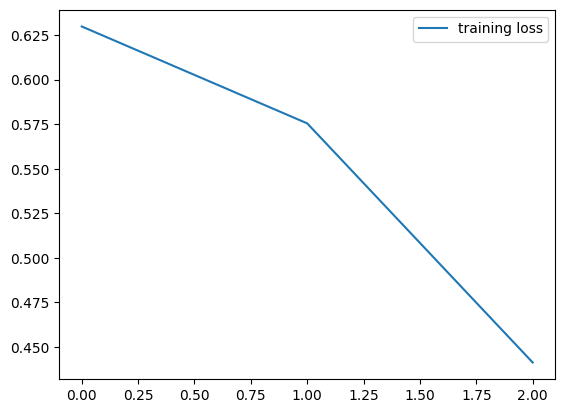

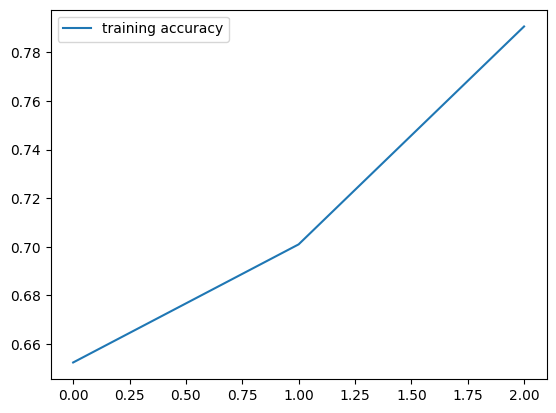

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.legend()
plt.show()

64/64 [==============================] - 11s 177ms/step


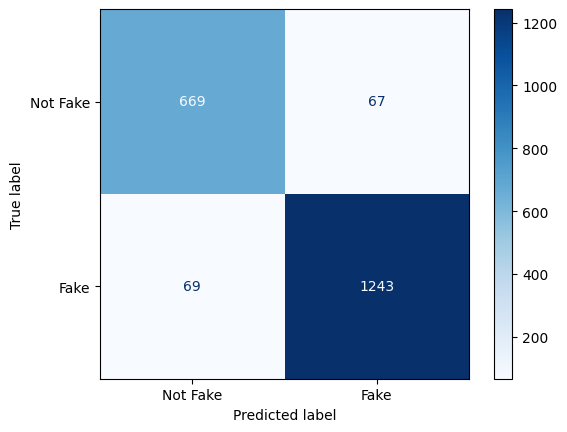

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Example: Split the data into training and testing sets
# Note: Replace this with your actual data splitting logic
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize test data
test_inputs = tokenizer(test_data['title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Make predictions on the test data
test_predictions = modelTransformerModel.predict(dict(test_inputs))
predicted_labels = np.argmax(test_predictions.logits, axis=1)

# True labels from the test set
true_labels = test_data['label'].values

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fake', 'Fake'])
disp.plot(cmap='Blues')

# Show the plot
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
test_inputs = tokenizer(test_data['title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Make predictions on the test data
test_predictions = modelTransformerModel.predict(dict(test_inputs))
predicted_labels = np.argmax(test_predictions.logits, axis=1)

# True labels from the test set
true_labels = test_data['label'].values

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

64/64 [==============================] - 11s 180ms/step
Accuracy: 0.9336


# **Using SimpleRNN Model**

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Creating model
embedding_vector_features = 40
modelSimpleRNN = Sequential()
modelSimpleRNN.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
modelSimpleRNN.add(SimpleRNN(100))
modelSimpleRNN.add(Dense(1, activation='sigmoid'))
modelSimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelSimpleRNN.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               14100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 214201 (836.72 KB)
Trainable params: 214201 (836.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
modelSimpleRNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
108/108 [==============================] - 11s 87ms/step - loss: 0.6542 - accuracy: 0.6445 - val_loss: 0.6526 - val_accuracy: 0.6428
Epoch 2/10
108/108 [==============================] - 6s 54ms/step - loss: 0.5765 - accuracy: 0.6926 - val_loss: 0.6962 - val_accuracy: 0.6067
Epoch 3/10
108/108 [==============================] - 6s 54ms/step - loss: 0.3573 - accuracy: 0.8465 - val_loss: 0.8788 - val_accuracy: 0.5762
Epoch 4/10
108/108 [==============================] - 9s 80ms/step - loss: 0.1817 - accuracy: 0.9284 - val_loss: 1.1518 - val_accuracy: 0.5780
Epoch 5/10
108/108 [==============================] - 4s 41ms/step - loss: 0.0979 - accuracy: 0.9675 - val_loss: 1.4105 - val_accuracy: 0.5812
Epoch 6/10
108/108 [==============================] - 3s 29ms/step - loss: 0.0717 - accuracy: 0.9765 - val_loss: 1.5781 - val_accuracy: 0.5661
Epoch 7/10
108/108 [==============================] - 4s 40ms/step - loss: 0.0446 - accuracy: 0.9880 - val_loss: 1.8398 - val_accuracy: 0.552

GRU *Gated Recurrent Unit*

In [ ]:
from tensorflow.keras.layers import GRU

# Creating model
embedding_vector_features = 40
modelGRU = Sequential()
modelGRU.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
modelGRU.add(GRU(100))
modelGRU.add(Dense(1, activation='sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelGRU.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            200000    
                                                                 
 gru_1 (GRU)                 (None, 100)               42600     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 242701 (948.05 KB)
Trainable params: 242701 (948.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
modelGRU.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
108/108 [==============================] - 11s 82ms/step - loss: 0.6540 - accuracy: 0.6430 - val_loss: 0.6438 - val_accuracy: 0.6431
Epoch 2/10
108/108 [==============================] - 3s 24ms/step - loss: 0.6043 - accuracy: 0.6722 - val_loss: 0.6429 - val_accuracy: 0.6493
Epoch 3/10
108/108 [==============================] - 2s 20ms/step - loss: 0.5233 - accuracy: 0.7366 - val_loss: 0.6991 - val_accuracy: 0.6227
Epoch 4/10
108/108 [==============================] - 1s 12ms/step - loss: 0.4480 - accuracy: 0.7828 - val_loss: 0.8014 - val_accuracy: 0.5869
Epoch 5/10
108/108 [==============================] - 1s 13ms/step - loss: 0.3884 - accuracy: 0.8200 - val_loss: 0.8568 - val_accuracy: 0.6132
Epoch 6/10
108/108 [==============================] - 2s 16ms/step - loss: 0.3375 - accuracy: 0.8520 - val_loss: 0.9518 - val_accuracy: 0.5792
Epoch 7/10
108/108 [==============================] - 1s 13ms/step - loss: 0.2962 - accuracy: 0.8727 - val_loss: 1.1027 - val_accuracy: 0.574

In [ ]:
# Save the model to a file
modelSimpleRNN.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_simple_rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modelGRU.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_gru_model.h5')

# **Confusion Matrix for SimpleRNN**

In [ ]:
y_pred_prob = modelSimpleRNN.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
conf_matrix

array([[ 446,  760],
       [ 694, 1479]])

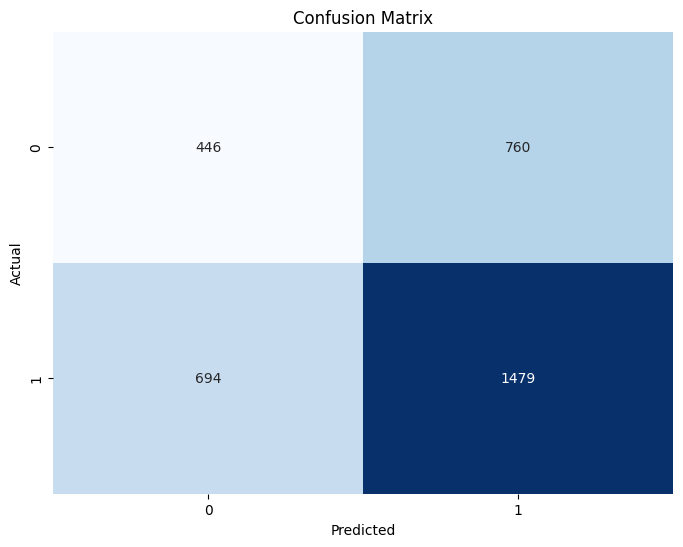

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Accuracy of SimpleRNN**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5696951760875999

# **Confusion Matrix for GRU Model**

In [ ]:
y_pred_prob = modelGRU.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
conf_matrix

array([[ 482,  724],
       [ 688, 1485]])

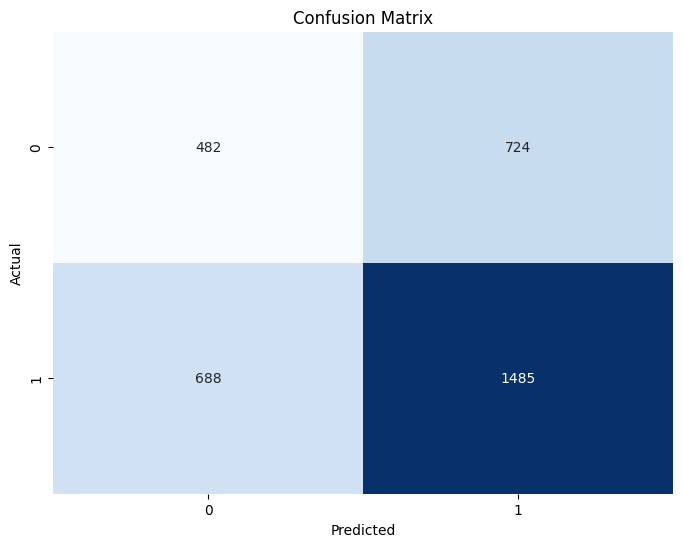

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Accuracy of GRUModel**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5821248890204203